In [ ]:
from utils import *

NOTEBOOK_ID = '18'
RUN_DIAMOND = False

# explore mycocosm sequences

In [ ]:
if RUN_DIAMOND:
    for csv_file in tqdm(glob(f'{DATASET_DIR}/03-waldburger/mycocosm_parsed/*csv')):
        csv_to_fasta(csv_file, f'{DATASET_DIR}/03-waldburger/mycocosm_fasta')
    os.system(f'cat {DATASET_DIR}/03-waldburger/mycocosm_fasta/*faa > {DATASET_DIR}/03-waldburger/mycocosm.faa')
    os.system(f'diamond makedb --in {DATASET_DIR}/03-waldburger/mycocosm.faa -d {DATASET_DIR}/03-waldburger/mycocosm_db')
    os.system(f'diamond blastp -d {DATASET_DIR}/03-waldburger/mycocosm_db.dmnd \
              -q {DATASET_DIR}/02-sanborn/paddle.faa -o {EXPLORE_DIR}/sanborn_matches.tsv --id 100')
    os.system(f'diamond blastp -d {DATASET_DIR}/03-waldburger/mycocosm_db.dmnd \
        -q {DATASET_DIR}/01-hummel/niklas.faa -o {EXPLORE_DIR}/hummel_matches.tsv --id 100')
    os.system(f'diamond blastp -d {DATASET_DIR}/03-waldburger/mycocosm_db.dmnd \
        -q {LIBRARY_DIR}/mycocosm_test.faa -o {EXPLORE_DIR}/mycocosm_matches.tsv --id 100')
    os.system(f'diamond blastp -d {DATASET_DIR}/03-waldburger/mycocosm_db.dmnd \
        -q {DATASET_DIR}/04-morffy/morffy.faa -o {EXPLORE_DIR}/morffy_matches.tsv --id 100')
    os.system(f'diamond blastp -d {DATASET_DIR}/03-waldburger/mycocosm_db.dmnd \
        -q {DATASET_DIR}/03-waldburger/harmonized.faa -o {EXPLORE_DIR}/harmonized_matches.tsv --id 100')

In [11]:
if not os.path.isfile(f'{EXPLORE_DIR}/03-waldburger/mycocosm_frequency_final.csv'):
    cols = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen','qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
    hummel_matches_df = pd.read_csv(f'{EXPLORE_DIR}/hummel_matches.tsv',sep='\t',names=cols)
    hummel_matches_df = hummel_matches_df.query('length == 53').reset_index(drop=True)
    hummel_matches_df['dataset'] = 'hummel'

    sanborn_matches_df = pd.read_csv(f'{EXPLORE_DIR}/sanborn_matches.tsv',sep='\t',names=cols)
    sanborn_matches_df = sanborn_matches_df.query('length == 53').reset_index(drop=True)
    sanborn_matches_df['dataset'] = 'sanborn'

    morffy_matches_df = pd.read_csv(f'{EXPLORE_DIR}/morffy_matches.tsv',sep='\t',names=cols)
    morffy_matches_df = morffy_matches_df.query('length == 40').reset_index(drop=True)
    morffy_matches_df['dataset'] = 'morffy'

    mycocosm_matches_df = pd.read_csv(f'{EXPLORE_DIR}/mycocosm_matches.tsv',sep='\t',names=cols)
    mycocosm_matches_df = mycocosm_matches_df.query('length == 53').reset_index(drop=True)
    mycocosm_matches_df['dataset'] = 'mycocosm'

    harmonized_matches_df = pd.read_csv(f'{EXPLORE_DIR}/harmonized_matches.tsv',sep='\t',names=cols)
    harmonized_matches_df = harmonized_matches_df.query('length == 53').reset_index(drop=True)
    harmonized_matches_df['dataset'] = 'harmonized'

    matches_df = pd.concat([hummel_matches_df, sanborn_matches_df, morffy_matches_df, mycocosm_matches_df, harmonized_matches_df]).reset_index(drop=True)
    matches_df['organism_id'] = matches_df['sseqid'].apply(lambda x: x.split('-')[0])
    matches_df.to_csv(f'{EXPLORE_DIR}/fungi_matches_final.csv',index=False)

    count_df = matches_df.groupby(['organism_id','dataset'])['qseqid'].count().reset_index().rename(columns={'qseqid':'count'})
    count_df['log10count'] = np.log10(count_df['count'])
    count_df = count_df.pivot(index='organism_id',columns='dataset',values='log10count').fillna(0.0)
    count_df.reset_index().to_csv(f'{EXPLORE_DIR}/mycocosm_frequency_final.csv',index=False)
else:
    matches_df = pd.read_csv(f'{EXPLORE_DIR}/fungi_matches_final.csv')
    count_df = pd.read_csv(f'{EXPLORE_DIR}/mycocosm_frequency_final.csv')

In [15]:
count_df = matches_df.groupby(['organism_id','dataset'])['qseqid'].count().reset_index().rename(columns={'qseqid':'count'})
count_df.groupby(['dataset'])['organism_id'].nunique()

dataset
harmonized    1071
hummel          21
morffy           9
mycocosm      1050
sanborn         69
Name: organism_id, dtype: int64

In [16]:
# mycocosm_set = set(count_df.query('dataset == "mycocosm"')['organism_id'].unique())
# sanborn_set = set(count_df.query('dataset == "sanborn"')['organism_id'].unique())
# hummel_set = set(count_df.query('dataset == "hummel"')['organism_id'].unique())

# from matplotlib_venn import venn3_unweighted
# venn3_unweighted(subsets = (mycocosm_set, sanborn_set, hummel_set), set_labels = ('mycocosm', 'sanborn', 'hummel'))

In [17]:
matches_df.groupby(['organism_id','dataset'])['qseqid'].count().reset_index()

,organism_id,dataset,qseqid
0,Aalte1,harmonized,2
1,Aalte1,mycocosm,2
2,Aaoar1,harmonized,31
3,Aaoar1,mycocosm,31
4,Abobi1,harmonized,15
...,...,...,...
2215,Zygro1,hummel,20
2216,Zygro1,sanborn,10
2217,Zygrou1,harmonized,20
2218,Zygrou1,hummel,20


In [18]:
matches_df.groupby(['dataset'])['organism_id'].count()

dataset
harmonized    47943
hummel        31433
morffy           25
mycocosm      13730
sanborn       36942
Name: organism_id, dtype: int64

# explore within test dataset

In [ ]:
hummel_df = pd.read_csv(f'{TARGET_DIR}/01-preprocess_dataset/hummel_preprocessed_Activity_500k_Rat.csv')[['AAseq','Activity_500k_Rat']]
X = np.asarray([[aa_to_i[aa] for aa in x] for x in hummel_df['AAseq']])
y = hummel_df['Activity_500k_Rat'].to_numpy()
threshold = hummel_df['Activity_500k_Rat'].median()
dataset, idx = split_dataset(X,y,threshold,scaler='standard')
_,_,test_idx = idx

In [ ]:




if not os.path.isfile(f'{DATASET_DIR}/03-waldburger/test_df_distances.csv'):
    test = pd.read_csv(f'{LIBRARY_DIR}/hummel_test.csv').rename(columns={'aa_seq':'AAseq'})
    other_seqs = list(hummel_df[~hummel_df['AAseq'].isin(test['AAseq'])]['AAseq'])

    test['min_distance'] = float('inf')
    for idx,row in tqdm(test.iterrows(),total=len(test)):
        test.loc[idx,'min_distance'] = min_hamming_distance(row['AAseq'],other_seqs)
    test.to_csv(f'{DATASET_DIR}/03-waldburger/test_df_distances.csv',index=False)
else:
    test = pd.read_csv(f'{DATASET_DIR}/03-waldburger/test_df_distances.csv')

if not os.path.isfile(f'{DATASET_DIR}/03-waldburger/mycocosm_distances.csv'):
    mycocosm_df = pd.read_csv(f'{LIBRARY_DIR}/mycocosm_test.csv').drop(columns=['Unnamed: 0'])
    test_idxs = np.load(f'{DATASET_DIR}/01-hummel/idx_test.npz')['arr']
    hummel_df['is_test'] = hummel_df.index.isin(test_idx)
    other_seqs = list(hummel_df.query('is_test == False')['AAseq'])

    mycocosm_df['min_distance'] = float('inf')
    for idx,row in tqdm(mycocosm_df.iterrows(),total=len(mycocosm_df)):
        mycocosm_df.loc[idx,'min_distance'] = min_hamming_distance(row['seq'],other_seqs)
    mycocosm_df.to_csv(f'{DATASET_DIR}/03-waldburger/mycocosm_distances.csv',index=False)
else:
    mycocosm_df = pd.read_csv(f'{DATASET_DIR}/03-waldburger/mycocosm_distances.csv')

In [8]:
if not os.path.isfile(f'{DATASET_DIR}/03-waldburger/sanborn_df_distances.csv'):
    sanborn_df = pd.read_csv(f'{LIBRARY_DIR}/sanborn_test.csv')
    sanborn_df['min_distance'] = float('inf')
    for idx,row in tqdm(sanborn_df.iterrows(),total=len(sanborn_df)):
        sanborn_df.loc[idx,'min_distance'] = min_hamming_distance(row['protein sequence'],other_seqs)
    sanborn_df.to_csv(f'{DATASET_DIR}/03-waldburger/sanborn_df_distances.csv')
else:
    sanborn_df = pd.read_csv(f'{DATASET_DIR}/03-waldburger/sanborn_df_distances.csv')

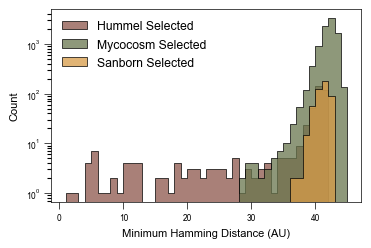

In [ ]:
plt.figure(figsize=(4,2.5))
g = sns.histplot(data=test,x='min_distance',binwidth=1,label='Hummel Selected',element='step',color=COLORS[10],edgecolor='black',linewidth=0.5)
sns.histplot(data=mycocosm_df,x='min_distance',binwidth=1,label='Mycocosm Selected',element='step',color='#69764d',edgecolor='black',linewidth=0.5)
sns.histplot(data=sanborn_df,x='min_distance',binwidth=1,label='Sanborn Selected',element='step',color='#d89b47',edgecolor='black',linewidth=0.5)
g.legend(frameon=False)
sns.move_legend(g, "upper left")
g.set(yscale='log',xlabel='Minimum Hamming Distance (AU)')

g.xaxis.set_tick_params(width=0.5)
g.yaxis.set_tick_params(width=0.5)
for axis in ['top','bottom','left','right']:
    g.spines[axis].set_linewidth(0.5)

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-hamming.png',dpi=400,transparent=False,bbox_inches='tight')